<a href="https://colab.research.google.com/github/pedroivovasconcelos/laboratorio_de_controle_ii_chuveiro/blob/master/Untitled3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install control

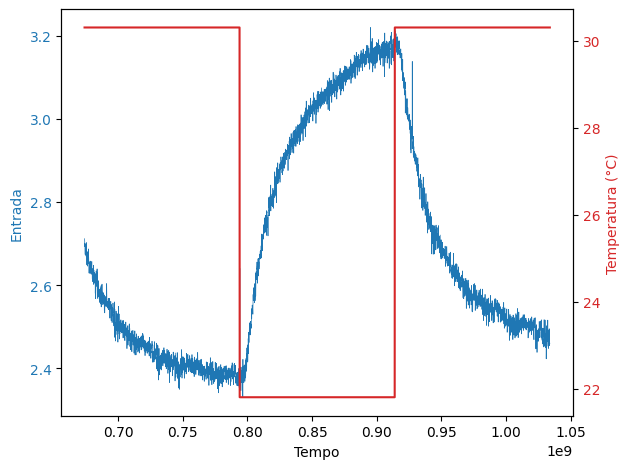

In [19]:
import numpy as np
import matplotlib.pyplot as plt

# Ler os dados do arquivo
filename = 'result1.txt'
tempo = []
entrada = []
saida = []

with open(filename, 'r') as file:
    lines = file.readlines()[1:]
    for line in lines:
        t, e, s, _ = line.strip().split(';')
        tempo.append(float(t))
        entrada.append(float(e))
        saida.append(float(s))

# Converter a entrada em volts para a temperatura em graus Celsius
entrada_volts = np.array(entrada)
entrada_celsius = np.interp(entrada_volts, [2.11, 2.76], [21.8, 30.3])

# Plotar os gráficos de entrada e temperatura
fig, ax1 = plt.subplots()

ax1.set_xlabel('Tempo')
ax1.set_ylabel('Entrada', color='tab:blue')
ax1.plot(tempo, entrada_celsius, color='tab:blue', linewidth=0.5)
ax1.tick_params(axis='y', labelcolor='tab:blue')

ax2 = ax1.twinx()
ax2.set_ylabel('Temperatura (°C)', color='tab:red')
ax2.plot(tempo, saida, color='tab:red')
ax2.tick_params(axis='y', labelcolor='tab:red')

fig.tight_layout()
plt.show()

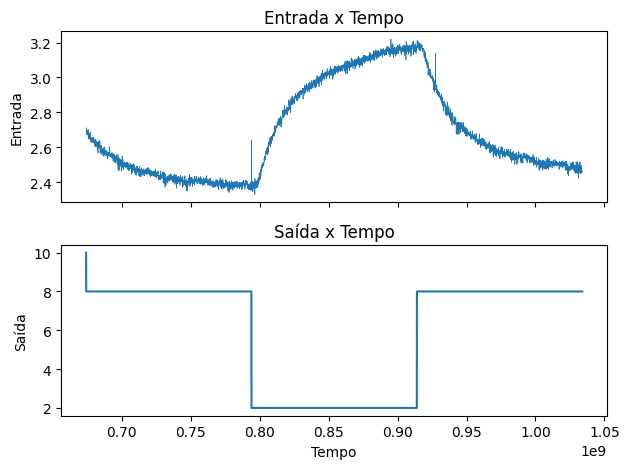

In [14]:
import matplotlib.pyplot as plt

# Ler os dados do arquivo
filename = 'result1.txt'
tempo = []
entrada = []
saida = []

with open(filename, 'r') as file:
    lines = file.readlines()[1:]
    for line in lines:
        t, e, s, _ = line.strip().split(';')
        tempo.append(float(t))
        entrada.append(float(e))
        saida.append(float(s))

# Plotar os gráficos
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
ax1.plot(tempo, entrada, linewidth=0.5)
ax1.set_title('Entrada x Tempo')
ax1.set_ylabel('Entrada')

ax2.plot(tempo, saida)
ax2.set_title('Saída x Tempo')
ax2.set_xlabel('Tempo')
ax2.set_ylabel('Saída')

plt.tight_layout()
plt.show()

In [ ]:
pip install statsmodels

Parâmetros estimados do modelo ARX:
const      -0.048120
saida.L1    0.999193
saida.L2    0.000768
entrada     0.017975
dtype: float64


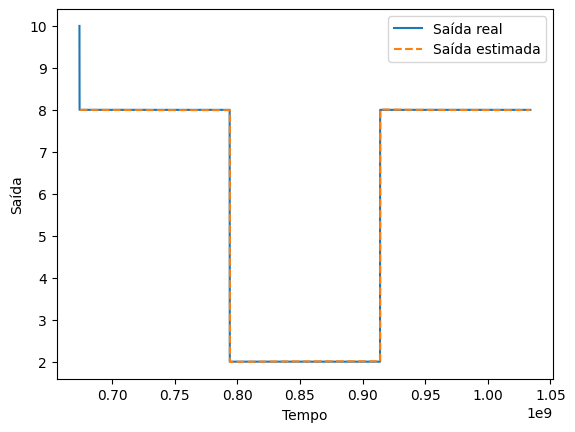

In [17]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt

# Ler os dados do arquivo
filename = 'result1.txt'
tempo = []
entrada = []
saida = []

with open(filename, 'r') as file:
    lines = file.readlines()[1:]
    for line in lines:
        t, e, s, _ = line.strip().split(';')
        tempo.append(float(t))
        entrada.append(float(e))
        saida.append(float(s))

# Converter os dados para um DataFrame do pandas
data = pd.DataFrame({"tempo": tempo, "entrada": entrada, "saida": saida})

# Ajustar o modelo ARX usando a biblioteca statsmodels
model = sm.tsa.AutoReg(data["saida"], lags=[1, 2], exog=data["entrada"]).fit()

# Imprimir os parâmetros estimados
print("Parâmetros estimados do modelo ARX:")
print(model.params)

# Simular a resposta do modelo estimado
saida_estimada = model.predict(start=0, end=len(data) - 1, exog_oos=data["entrada"])

# Plotar a resposta do modelo estimado e a saída real
plt.plot(tempo, saida, label="Saída real")
plt.plot(tempo, saida_estimada, label="Saída estimada", linestyle="--")
plt.xlabel("Tempo")
plt.ylabel("Saída")
plt.legend()
plt.show()


In [28]:
import numpy as np
import pandas as pd
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

# Função de transferência de primeira ordem
def first_order_tf(t, K, tau, y0):
    return K * (1 - np.exp(-t / tau)) + y0

# Ler os dados do arquivo
filename = 'result1.txt'
data = pd.read_csv(filename, delimiter=';', skiprows=1, names=['tempo', 'entrada', 'saida'])

tempo = data['tempo'].to_numpy()
entrada = data['entrada'].to_numpy()
saida = data['saida'].to_numpy()

# Verificar se há valores NaN ou inf nos dados
print("Valores NaN na entrada:", np.isnan(entrada).any())
print("Valores inf na entrada:", np.isinf(entrada).any())
print("Valores NaN na saída:", np.isnan(saida).any())
print("Valores inf na saída:", np.isinf(saida).any())

# Remover quaisquer valores NaN ou inf nos dados
tempo = tempo[np.isfinite(entrada) & np.isfinite(saida)]
entrada = entrada[np.isfinite(entrada) & np.isfinite(saida)]
saida = saida[np.isfinite(entrada) & np.isfinite(saida)]

# Estimar os parâmetros K, tau e y0 da função de transferência de primeira ordem
params, _ = curve_fit(first_order_tf, tempo, saida, p0=[1, 1, 1])

K, tau, y0 = params
print(f'K: {K}, tau: {tau}, y0: {y0}')

# Gerar a resposta ao degrau unitário usando a função de transferência estimada
saida_estimada = first_order_tf(tempo, K, tau, y0)

# Plotar a resposta ao degrau real e a resposta ao degrau estimada
plt.plot(tempo, saida, label='Resposta ao degrau real')
plt.plot(tempo, saida_estimada, linestyle='--', label='Resposta ao degrau estimada')
plt.xlabel('Tempo')
plt.ylabel('Resposta ao degrau')
plt.legend()
plt.show()


Valores NaN na entrada: False
Valores inf na entrada: False
Valores NaN na saída: True
Valores inf na saída: False


ValueError: ignored

In [29]:
import numpy as np
import pandas as pd
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

# Função de transferência de primeira ordem
def first_order_tf(t, K, tau, y0):
    return K * (1 - np.exp(-t / tau)) + y0

# Ler os dados do arquivo
filename = 'result1.txt'
data = pd.read_csv(filename, delimiter=';', skiprows=1, names=['tempo', 'entrada', 'saida'])

tempo = data['tempo'].to_numpy()
entrada = data['entrada'].to_numpy()
saida = data['saida'].to_numpy()

# Verificar se há valores NaN ou inf nos dados
print("Valores NaN na entrada:", np.isnan(entrada).any())
print("Valores inf na entrada:", np.isinf(entrada).any())
print("Valores NaN na saída:", np.isnan(saida).any())
print("Valores inf na saída:", np.isinf(saida).any())

# Remover quaisquer valores NaN ou inf nos dados
mask = np.isfinite(entrada) & np.isfinite(saida)
tempo = tempo[mask]
entrada = entrada[mask]
saida = saida[mask]

# Estimar os parâmetros K, tau e y0 da função de transferência de primeira ordem
params, _ = curve_fit(first_order_tf, tempo, saida, p0=[1, 1, 1])

K, tau, y0 = params
print(f'K: {K}, tau: {tau}, y0: {y0}')

# Gerar a resposta ao degrau unitário usando a função de transferência estimada
saida_estimada = first_order_tf(tempo, K, tau, y0)

# Plotar a resposta ao degrau real e a resposta ao degrau estimada
plt.plot(tempo, saida, label='Resposta ao degrau real')
plt.plot(tempo, saida_estimada, linestyle='--', label='Resposta ao degrau estimada')
plt.xlabel('Tempo')
plt.ylabel('Resposta ao degrau')
plt.legend()
plt.show()

Valores NaN na entrada: False
Valores inf na entrada: False
Valores NaN na saída: True
Valores inf na saída: False


ValueError: ignored

Valores NaN na entrada: False
Valores inf na entrada: False
Valores NaN na saída: True
Valores inf na saída: False

Índices dos valores NaN na saída:
(array([   0,    1,    2, ..., 3597, 3598, 3599]),)
K: 1.8137387492202383e-159, tau: 1.0000001722903684, y0: -6.978378159460703e-160


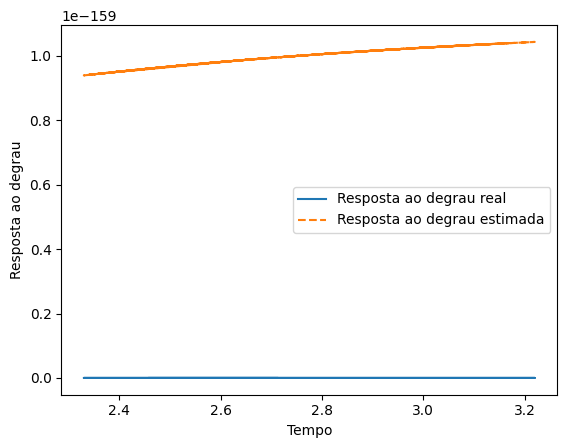

In [30]:
import numpy as np
import pandas as pd
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

# Função de transferência de primeira ordem
def first_order_tf(t, K, tau, y0):
    return K * (1 - np.exp(-t / tau)) + y0

# Ler os dados do arquivo
filename = 'result1.txt'
data = pd.read_csv(filename, delimiter=';', skiprows=1, names=['tempo', 'entrada', 'saida'])

tempo = data['tempo'].to_numpy()
entrada = data['entrada'].to_numpy()
saida = data['saida'].to_numpy()

# Verificar se há valores NaN ou inf nos dados
print("Valores NaN na entrada:", np.isnan(entrada).any())
print("Valores inf na entrada:", np.isinf(entrada).any())
print("Valores NaN na saída:", np.isnan(saida).any())
print("Valores inf na saída:", np.isinf(saida).any())

print("\nÍndices dos valores NaN na saída:")
print(np.where(np.isnan(saida)))

saida = np.nan_to_num(saida)

mask = np.isfinite(entrada) & np.isfinite(saida)
tempo = tempo[mask]
entrada = entrada[mask]
saida = saida[mask]

# Estimar os parâmetros K, tau e y0 da função de transferência de primeira ordem
params, _ = curve_fit(first_order_tf, tempo, saida, p0=[1, 1, 1])

K, tau, y0 = params
print(f'K: {K}, tau: {tau}, y0: {y0}')

# Gerar a resposta ao degrau unitário usando a função de transferência estimada
saida_estimada = first_order_tf(tempo, K, tau, y0)

# Plotar a resposta ao degrau real e a resposta ao degrau estimada
plt.plot(tempo, saida, label='Resposta ao degrau real')
plt.plot(tempo, saida_estimada, linestyle='--', label='Resposta ao degrau estimada')
plt.xlabel('Tempo')
plt.ylabel('Resposta ao degrau')
plt.legend()
plt.show()

In [46]:
from math import exp
t0 = 10**8*7.9772
tf = 10**8*9.1599
K = (2.3781-3.1844)/(8-2)
vr = (2.3781-3.1844)*-1*0.632+2.3781
tr = 827831000
tau = (tr - t0)/10**6
print(f"{K},\n{t0},\n{tf},\n{vr},\n{tau}")

-0.13438333333333338,
797720000.0,
915990000.0,
2.8876816,
30.111


In [51]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt

# Função para criar um filtro passa-baixa Butterworth
def butter_lowpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

# Função para aplicar o filtro passa-baixa Butterworth ao sinal
def butter_lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = filtfilt(b, a, data)
    return y

# Dados de exemplo (substitua pelos seus dados de entrada e saída)
filename = 'result1.txt'
data = pd.read_csv(filename, delimiter=';', skiprows=1, names=['tempo', 'entrada', 'saida'])

t = data['tempo'].to_numpy()
entrada = data['entrada'].to_numpy()
saida = data['saida'].to_numpy()

# t = np.linspace(0, 10, 1000)
# entrada = np.zeros_like(t)
# entrada[t > 1] = 1
# saida = 2 * (1 - np.exp(-(t-1)/0.5)) * (t > 1)
# saida += np.random.normal(0, 0.1, len(t))  
# Adicionando ruído

# Aplicar o filtro passa-baixa Butterworth
fs = 1000 / (t[-1] - t[0])  # Frequência de amostragem
cutoff = 10  # Frequência de corte do filtro (escolha um valor adequado)
saida_filtrada = butter_lowpass_filter(saida, cutoff, fs)

# Plotar entrada e saída filtrada
plt.figure()
plt.plot(t, entrada, label='Entrada')
plt.plot(t, saida, label='Saída')
plt.plot(t, saida_filtrada, label='Saída Filtrada')
plt.legend()
plt.show()

# Estimar atraso, K e tau usando o método da curva de reação
degrau_entrada = np.argmax(np.diff(entrada))
degrau_saida = np.argmax(np.diff(saida_filtrada))
atraso = t[degrau_saida] - t[degrau_entrada]

K = (saida_filtrada[-1] - saida_filtrada[0]) / (entrada[-1] - entrada[0])
tr_index = np.argmax(saida_filtrada >= 0.632 * (saida_filtrada[-1] - saida_filtrada[0]) + saida_filtrada[0])
tau = t[tr_index] - t[degrau_saida]

print(f"Atraso: {atraso}, K: {K}, tau: {tau}")


ValueError: ignored

/usr/local/lib/python3.9/dist-packages/scipy/optimize/_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


K: -207.43926862750658
tau (s): 1e-12
y0: 213.4392686183036


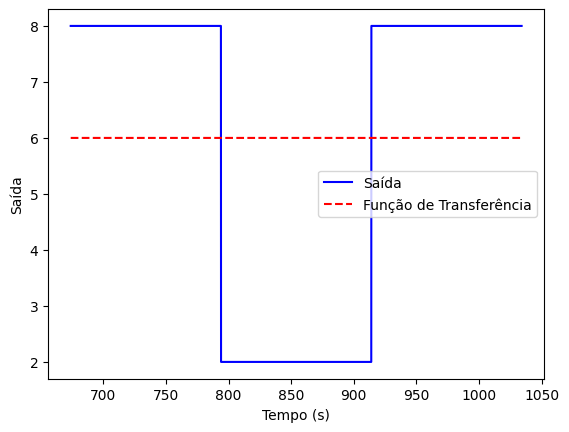

In [50]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import medfilt
from scipy.optimize import curve_fit

# Definir função de transferência de primeira ordem
def first_order_tf(t, K, tau, y0):
    return K*(1 - np.exp(-t/tau)) + y0

# Ler dados do arquivo CSV
data = np.genfromtxt('result1.txt', delimiter=';', skip_header=1)

# Extrair tempo, entrada e saída
tempo = data[:, 0]/1e6  # Converter tempo de microssegundos para segundos
entrada = data[:, 1]
saida = data[:, 2]

# Remover ruído da entrada e da saída
entrada_filtrada = medfilt(entrada, kernel_size=5)
saida_filtrada = medfilt(saida, kernel_size=5)

# Estimar os parâmetros K, tau e y0 da função de transferência de primeira ordem
params, _ = curve_fit(first_order_tf, tempo, saida_filtrada, p0=[1, 1e-6, 0])

K, tau, y0 = params

print('K:', K)
print('tau (s):', tau/1e6)
print('y0:', y0)

# Plotar o resultado
plt.plot(tempo, saida_filtrada, 'b-', label='Saída')
plt.plot(tempo, first_order_tf(tempo, K, tau, y0), 'r--', label='Função de Transferência')
plt.xlabel('Tempo (s)')
plt.ylabel('Saída')
plt.legend()
plt.show()
